In [ ]:
import os
import subprocess
import warnings
from collections import defaultdict
from typing import Any

import cv2 as cv
import gdown
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import supervision as sv
from IPython.display import Video
from numpy.typing import ArrayLike, NDArray
from scipy.signal import savgol_filter
from ultralytics import YOLO

TICKSIZE = 12
FONT_COLOR = "#4A4B52"
GRADIENT_COLOR = "#BAB8B8"
BACKGROUND_COLOR = "#FFFCFA"

MATPLOTLIB_THEME = {
    "axes.labelcolor": FONT_COLOR,
    "axes.labelsize": TICKSIZE,
    "axes.facecolor": BACKGROUND_COLOR,
    "axes.titlesize": 16,
    "axes.grid": False,
    "axes.spines.bottom": False,
    "axes.spines.left": False,
    "axes.spines.right": False,
    "axes.spines.top": False,
    "xtick.labelsize": TICKSIZE,
    "xtick.color": FONT_COLOR,
    "ytick.labelsize": TICKSIZE,
    "ytick.color": FONT_COLOR,
    "figure.facecolor": BACKGROUND_COLOR,
    "figure.edgecolor": BACKGROUND_COLOR,
    "figure.titlesize": 16,
    "figure.dpi": 72,  # Locally Seaborn uses 72, meanwhile Kaggle 96.
    "text.color": FONT_COLOR,
    "font.size": TICKSIZE,
    # "text.usetex": True,
    "font.family": "Serif",
}
plt.rcParams.update(MATPLOTLIB_THEME)

VIDEO_URL = "https://drive.google.com/uc?export=download&id=17BLLWPJP4hpzLw135SI3rQPaWtItM0lR"
SOURCE_VIDEO = gdown.cached_download(VIDEO_URL, "m6-motorway-trim.mp4")


def imshow(img, figsize: tuple[int, int] = (11, 7)) -> None:
    plt.figure(figsize=figsize, tight_layout=True)
    plt.imshow(img)
    plt.axis("off")
    plt.show()
    


In [ ]:
from ultralytics import YOLO

# Load the YOLOv5s model (or you can download a different model like yolov5m, yolov5l, etc.)
yolo = YOLO('yolov5s.pt')  # This will download the pre-trained weights if they aren't already on your system


In [ ]:
Video(SOURCE_VIDEO, width=960, height=540)
class PointMarker:
    """Mark points on an image using Left Mouse Button click."""

    def __init__(self, window: str = "Image") -> None:
        self._window = window
        self._points: list[tuple[int, int]] = list()

    def __call__(self, image: NDArray, inplace: bool = False) -> list[tuple[int, int]]:
        return self.mark(image, inplace)

    @property
    def points(self) -> list[tuple[int, int]]:
        return self._points

    def mark(self, image: NDArray, inplace: bool = False) -> list[tuple[int, int]]:
        if not inplace:
            image = image.copy()
        cv.namedWindow(self._window, cv.WINDOW_NORMAL)
        cv.setMouseCallback(self._window, self._record_point, param=image)

        while True:
            cv.imshow(self._window, image)
            if cv.waitKey(1) == ord("q"):
                break

        cv.destroyAllWindows()
        return self._points

    def _record_point(self, event: int, x: int, y: int, flags: int, image: Any | None) -> None:
        if event == cv.EVENT_LBUTTONDOWN:
            self._points.append((x, y))
            if image is not None:
                self._draw_point(image, (x, y))

    def _draw_point(self, image: NDArray, point: tuple[int, int]) -> None:
        cv.drawMarker(image, point, (0, 123, 255), cv.MARKER_CROSS, 20, 4, cv.LINE_AA)
        
cap = cv.VideoCapture(SOURCE_VIDEO)
ret, img = cap.read()
cap.release()

img = cv.cvtColor(cv.cvtColor(img, cv.COLOR_BGR2GRAY), cv.COLOR_GRAY2BGR)

color1 = sv.Color.from_hex("#004080")
color2 = sv.Color.from_hex("#f78923")
poly = np.array(((800, 410), (1125, 410), (1920, 850), (0, 850)))

class Cam2WorldMapper:
    """Maps points from image to world coordinates using perspective transform."""

    def __init__(self) -> None:
        self.M: NDArray | None = None

    def __call__(self, image_pts: ArrayLike) -> NDArray:
        return self.map(image_pts)

    def find_perspective_transform(self, image_pts: ArrayLike, world_pts: ArrayLike) -> NDArray:
        image_pts = np.asarray(image_pts, dtype=np.float32).reshape(-1, 1, 2)
        world_pts = np.asarray(world_pts, dtype=np.float32).reshape(-1, 1, 2)
        self.M = cv.getPerspectiveTransform(image_pts, world_pts)
        return self.M

    def map(self, image_pts: ArrayLike) -> NDArray:
        if self.M is None:
            raise ValueError("Perspective transform not estimated")
        image_pts = np.asarray(image_pts, dtype=np.float32).reshape(-1, 1, 2)
        return cv.perspectiveTransform(image_pts, self.M).reshape(-1, 2)             

# A, B, C, D previously found in the image.
image_pts = [(800, 410), (1125, 410), (1920, 850), (0, 850)]
# M6 is roughly 32 meters wide and 140 meters long there.
world_pts = [(0, 0), (32, 0), (32, 140), (0, 140)] 

mapper = Cam2WorldMapper()
mapper.find_perspective_transform(image_pts, world_pts)
MPS_TO_KPH = 3.6


class Speedometer:
    """Estimates speed of objects in the world coordinates."""

    def __init__(self, mapper: Cam2WorldMapper, fps: int, unit: float = MPS_TO_KPH) -> None:
        self._mapper = mapper
        self._fps = fps
        self._unit = unit
        self._speeds: defaultdict[int, list[int]] = defaultdict(list)

    @property
    def speeds(self) -> defaultdict[int, list[int]]:
        return self._speeds

    def update_with_trace(self, idx: int, image_trace: NDArray) -> None:
        if len(image_trace) > 1:
            world_trace = self._mapper(image_trace)
            # Median displacement in x and y directions.
            # This stabilises after around several frames.
            dx, dy = np.median(np.abs(np.diff(world_trace, axis=0)), axis=0)
            ds = np.linalg.norm((dx, dy))
            self._speeds[idx].append(int(ds * self._fps * self._unit))

    def get_current_speed(self, idx: int) -> int:
        return self._speeds[idx][-1] if self._speeds[idx] else 0
    

# Custom color palette for object tracking.
colors = ("#007fff", "#0072e6", "#0066cc", "#0059b3", "#004c99", "#004080", "#003366", "#00264d")
color_palette = sv.ColorPalette(list(map(sv.Color.from_hex, colors)))

# The supervision VideoInfo provides some metadata about the video.
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO)
FPS = video_info.fps

# Polygonal zone that masks out detected objects that are outside it.
poly = np.array([(0, 410), (1920, 410), (1920, 900), (0, 900)])
zone = sv.PolygonZone(poly, (sv.Position.TOP_CENTER, sv.Position.BOTTOM_CENTER))

bbox_annotator = sv.BoxAnnotator(
    color=color_palette,
    thickness=2,
    color_lookup=sv.ColorLookup.TRACK,
)
trace_annotator = sv.TraceAnnotator(
    color=color_palette,
    position=sv.Position.CENTER,
    thickness=2,
    trace_length=FPS,
    color_lookup=sv.ColorLookup.TRACK,
)
label_annotator = sv.RichLabelAnnotator(
    color=color_palette,
    border_radius=2,
    font_size=16,
    color_lookup=sv.ColorLookup.TRACK,
    text_padding=6,
)


yolo = YOLO("yolo11m.pt", task="detect")
speedometer = Speedometer(mapper, FPS)

output_video = "m6-motorway-annotated.mp4"
width, height = video_info.resolution_wh  # Inferenced image size
# YOLO expects the image size to be a multiple of 32
width, height = round(width / 32) * 32, round(height / 32) * 32
classes = [2, 5, 7]  # Car, Bus, Truck
conf = 0.4  # Detetion confidence threshold

with sv.VideoSink(output_video, video_info) as sink:
    for frame in sv.get_video_frames_generator(SOURCE_VIDEO):
        result = yolo.track(
            frame,
            classes=classes,
            conf=conf,
            imgsz=(height, width),
            persist=True,
            verbose=False,
            tracker="bytetrack.yaml",
        )
        detection = sv.Detections.from_ultralytics(result[0])
        # Mask out detections outside the zone.
        detection = detection[zone.trigger(detections=detection)]

        trace_ids = detection.tracker_id  # type: ignore
        speeds: list[int] = list()
        labels: list[str] = list()

        for trace_id in trace_ids:  # type: ignore
            image_trace = trace_annotator.trace.get(trace_id)
            speedometer.update_with_trace(int(trace_id), image_trace)
            current_speed = speedometer.get_current_speed(int(trace_id))
            speeds.append(current_speed)
            labels.append(f"#{trace_id} {current_speed} km/h")

        frame = cv.cvtColor(cv.cvtColor(frame, cv.COLOR_BGR2GRAY), cv.COLOR_GRAY2RGB)
        frame = bbox_annotator.annotate(frame, detection)  # type: ignore
        frame = trace_annotator.annotate(frame, detection)  # type: ignore
        frame = label_annotator.annotate(frame, detection, labels=labels)  # type: ignore
        sink.write_frame(frame)
        
        warnings.simplefilter("ignore")
speed_df = pd.DataFrame.from_dict(speedometer.speeds, orient="index").transpose()
speed_df = speed_df.clip(  # Remove extreme outliers and smooth the curve.
    lower=float(np.nanpercentile(speed_df, 1)),
    upper=float(np.nanpercentile(speed_df, 99)),
).apply(lambda x: savgol_filter(x, FPS, 2))

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 9), tight_layout=True)
sns.lineplot(speed_df, palette="mako", linewidth=1.25, ax=ax1)
ax1.set_xlabel("Frame")
ax1.set_ylabel("Speed (km/h)")
ax1.get_legend().set_visible(False)
ax1.set_ylim(10, 140)
ax1.set_title(
    "M6 Highway near Knutsford, UK - Speed Distribution",
    loc="left",
    pad=40,
)
sns.kdeplot(speed_df.to_numpy().ravel(), fill=True, color="#004080", linewidth=1, ax=ax2)
ax2.set_xlabel("Speed (km/h)")
ax2.set_ylabel("Density")
plt.show()



In [ ]:
import cv2 as cv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
from typing import Any, Optional
from scipy.signal import savgol_filter
from ultralytics import YOLO
import supervision as sv


import warnings

SOURCE_VIDEO = "m6-motorway-trim.mp4"

class PointMarker:
    """Mark points on an image using Left Mouse Button click."""

    def __init__(self, window: str = "Image") -> None:
        self._window = window
        self._points: list[tuple[int, int]] = list()

    def __call__(self, image: np.ndarray, inplace: bool = False) -> list[tuple[int, int]]:
        return self.mark(image, inplace)

    @property
    def points(self) -> list[tuple[int, int]]:
        return self._points

    def mark(self, image: np.ndarray, inplace: bool = False) -> list[tuple[int, int]]:
        if not inplace:
            image = image.copy()
        cv.namedWindow(self._window, cv.WINDOW_NORMAL)
        cv.setMouseCallback(self._window, self._record_point, param=image)

        while True:
            cv.imshow(self._window, image)
            if cv.waitKey(1) == ord("q"):
                break

        cv.destroyAllWindows()
        return self._points

    def _record_point(self, event: int, x: int, y: int, flags: int, image: Optional[np.ndarray]) -> None:
        if event == cv.EVENT_LBUTTONDOWN:
            self._points.append((x, y))
            if image is not None:
                self._draw_point(image, (x, y))

    def _draw_point(self, image: np.ndarray, point: tuple[int, int]) -> None:
        cv.drawMarker(image, point, (0, 123, 255), cv.MARKER_CROSS, 20, 4, cv.LINE_AA)

class Cam2WorldMapper:
    """Maps points from image to world coordinates using perspective transform."""

    def __init__(self) -> None:
        self.M: np.ndarray | None = None

    def find_perspective_transform(self, image_pts, world_pts) -> np.ndarray:
        image_pts = np.asarray(image_pts, dtype=np.float32).reshape(-1, 1, 2)
        world_pts = np.asarray(world_pts, dtype=np.float32).reshape(-1, 1, 2)
        self.M = cv.getPerspectiveTransform(image_pts, world_pts)
        return self.M

    def map(self, image_pts) -> np.ndarray:
        if self.M is None:
            raise ValueError("Perspective transform not estimated")
        image_pts = np.asarray(image_pts, dtype=np.float32).reshape(-1, 1, 2)
        return cv.perspectiveTransform(image_pts, self.M).reshape(-1, 2)

MPS_TO_KPH = 3.6

class Speedometer:
    """Estimates speed of objects in world coordinates."""

    def __init__(self, mapper: Cam2WorldMapper, fps: int, unit: float = MPS_TO_KPH, smoothing_window: int = 5) -> None:
        self._mapper = mapper
        self._fps = fps
        self._unit = unit
        self._speeds: defaultdict[int, list[int]] = defaultdict(list)
        self._smoothing_window = smoothing_window

    def update_with_trace(self, idx: int, image_trace: np.ndarray) -> None:
        if len(image_trace) > 1:
            world_trace = self._mapper.map(image_trace)
            dx, dy = np.median(np.abs(np.diff(world_trace, axis=0)), axis=0)
            ds = np.linalg.norm((dx, dy))
            self._speeds[idx].append(int(ds * self._fps * self._unit))

            # Apply smoothing (moving average) to the speed history
            if len(self._speeds[idx]) > self._smoothing_window:
                self._speeds[idx] = self._speeds[idx][-self._smoothing_window:]

    def get_current_speed(self, idx: int) -> int:
        return int(np.mean(self._speeds[idx])) if self._speeds[idx] else 0
    
# Custom color palette for object tracking.
colors = ("#007fff", "#0072e6", "#0066cc", "#0059b3", "#004c99", "#004080", "#003366", "#00264d")
color_palette = sv.ColorPalette(list(map(sv.Color.from_hex, colors)))

# The supervision VideoInfo provides some metadata about the video.
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO)
FPS = video_info.fps

# Polygonal zone that masks out detected objects that are outside it.
poly = np.array([(0, 410), (1920, 410), (1920, 900), (0, 900)])
zone = sv.PolygonZone(poly, (sv.Position.TOP_CENTER, sv.Position.BOTTOM_CENTER))
    
    
bbox_annotator = sv.BoxAnnotator(
    color=color_palette,
    thickness=2,
    color_lookup=sv.ColorLookup.TRACK,
)
trace_annotator = sv.TraceAnnotator(
    color=color_palette,
    position=sv.Position.CENTER,
    thickness=2,
    trace_length=FPS,
    color_lookup=sv.ColorLookup.TRACK,
)
label_annotator = sv.RichLabelAnnotator(
    color=color_palette,
    border_radius=2,
    font_size=16,
    color_lookup=sv.ColorLookup.TRACK,
    text_padding=6,
)

cap = cv.VideoCapture(SOURCE_VIDEO)
if not cap.isOpened():
    raise IOError("Error opening video file")

FPS = cap.get(cv.CAP_PROP_FPS)
print(f"FPS: {FPS}")  # Check the FPS value here to make sure it's correct


# Define reference points (Update these values based on your setup)
image_pts = [(100, 500), (1800, 500), (100, 800), (1800, 800)]  # Image coordinates
world_pts = [(0, 0), (50, 0), (0, 50), (50, 50)]  # Corresponding real-world coordinates in meters

# Initialize and compute perspective transformation
mapper = Cam2WorldMapper()
mapper.find_perspective_transform(image_pts, world_pts)

# Pass the initialized mapper to Speedometer
speedometer = Speedometer(mapper, FPS)

yolo = YOLO("yolov5su.pt", task="detect")  # Enable FP16

classes = [2, 5, 7]  # Car, Bus, Truck
conf = 0.4  # Detection confidence threshold

frame_skip = 1# Process every frame
frame_count = 0
while True:
    ret, frame = cap.read()
    if not ret:
        break  # Exit if no more frames

    frame_count += 1
    if frame_count % frame_skip != 0:
        continue  # Skip processing this frame

    result = yolo.track(frame, classes=classes, conf=conf, persist=True, verbose=False, tracker="bytetrack.yaml")
    detection = sv.Detections.from_ultralytics(result[0])

    # Define the zone where we want to focus detection (you can adjust it)
    poly = np.array([(0, 410), (1920, 410), (1920, 900), (0, 900)])
    zone = sv.PolygonZone(poly, (sv.Position.TOP_CENTER, sv.Position.BOTTOM_CENTER))
    detection = detection[zone.trigger(detections=detection)]

    trace_ids = detection.tracker_id
    speeds, labels = [], []

    for trace_id in trace_ids:
        image_trace = trace_annotator.trace.get(trace_id)
        speedometer.update_with_trace(int(trace_id), image_trace)
        current_speed = speedometer.get_current_speed(int(trace_id))
        speeds.append(current_speed)
        labels.append(f"#{trace_id} {current_speed} km/h")

    # Annotate the frame
    frame = bbox_annotator.annotate(frame, detection)
    frame = trace_annotator.annotate(frame, detection)
    frame = label_annotator.annotate(frame, detection, labels=labels)

    # Resize the window to a smaller size (e.g., 1280x720)
    window_width = 1280
    window_height = 720
    cv.namedWindow("Processed Frame", cv.WINDOW_NORMAL)
    cv.resizeWindow("Processed Frame", window_width, window_height)

    # Display the resized frame
    cv.imshow("Processed Frame", frame)

    # Exit the loop when 'q' is pressed
    if cv.waitKey(1) == ord('q'):
        break


# Release resources after processing
cap.release()
cv.destroyAllWindows()


In [ ]:
import cv2 as cv
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import supervision as sv


# Path to the video source
SOURCE_VIDEO = "m6-motorway-trim.mp4"

# Open the video
cap = cv.VideoCapture(SOURCE_VIDEO)
ret, img = cap.read()
cap.release()

# Convert to grayscale and back to BGR for coloring later
img = cv.cvtColor(cv.cvtColor(img, cv.COLOR_BGR2GRAY), cv.COLOR_GRAY2BGR)

# Define polygon points and colors
color1 = sv.Color.from_hex("#004080")
color2 = sv.Color.from_hex("#f78923")
poly = np.array(((830, 380), (1155, 380), (1920, 850), (0, 850)))  # Polygon vertices

# Draw filled polygon
img = sv.draw_filled_polygon(img, poly, color1, 0.5)
# Draw polygon border
img = sv.draw_polygon(img, poly, sv.Color.WHITE, 12)

# Add labels to the corners of the polygon
img = sv.draw_text(img, "A", sv.Point(830, 370), color2, 2, 6)
img = sv.draw_text(img, "B", sv.Point(1125, 370), color2, 2, 6)
img = sv.draw_text(img, "C", sv.Point(1880, 780), color2, 2, 6)
img = sv.draw_text(img, "D", sv.Point(40, 780), color2, 2, 6)

# Display the image with drawn polygon and text using OpenCV (same as matplotlib window size)
cv.namedWindow("Processed Frame", cv.WINDOW_NORMAL)
cv.resizeWindow("Processed Frame", 1280, 720)  # Resize to 1280x720
cv.imshow("Processed Frame", img)

# Wait until a key is pressed and then close the window
cv.waitKey(0)
cv.destroyAllWindows()


In [ ]:

# Now you can process the speed data for plotting
speed_df = pd.DataFrame.from_dict(speedometer._speeds, orient="index").transpose()
speed_df = speed_df.clip(lower=np.nanpercentile(speed_df, 1), upper=np.nanpercentile(speed_df, 99)).apply(lambda x: savgol_filter(x, FPS, 2))

# Plot the speed data
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 9), tight_layout=True)
sns.lineplot(speed_df, palette="mako", linewidth=1.25, ax=ax1)
ax1.set_xlabel("Frame")
ax1.set_ylabel("Speed (km/h)")
ax1.set_ylim(10, 140)
ax1.set_title("M6 Highway near Knutsford, UK - Speed Distribution", loc="left", pad=40)
sns.kdeplot(speed_df.to_numpy().ravel(), fill=True, color="#004080", linewidth=1, ax=ax2)
ax2.set_xlabel("Speed (km/h)")
ax2.set_ylabel("Density")
plt.show()

In [ ]:
    import argparse
    from collections import defaultdict, deque

    import cv2
    import numpy as np
    from ultralytics import YOLO

    import supervision as sv


    SOURCE = np.array(((800, 410), (1125, 410), (1920, 850), (0, 850)))


    TARGET_WIDTH = 32
    TARGET_HEIGHT = 140

    TARGET = np.array(
        [
            [0, 0],
            [TARGET_WIDTH - 1, 0],
            [TARGET_WIDTH - 1, TARGET_HEIGHT - 1],
            [0, TARGET_HEIGHT - 1],
        ]
    )


    class ViewTransformer:
        def __init__(self, source: np.ndarray, target: np.ndarray) -> None:
            source = source.astype(np.float32)
            target = target.astype(np.float32)
            self.m = cv2.getPerspectiveTransform(source, target)

        def transform_points(self, points: np.ndarray) -> np.ndarray:
            if points.size == 0:
                return points

            reshaped_points = points.reshape(-1, 1, 2).astype(np.float32)
            transformed_points = cv2.perspectiveTransform(reshaped_points, self.m)
            return transformed_points.reshape(-1, 2)




    if __name__ == "__main__":

        video_info = sv.VideoInfo.from_video_path(video_path='./asset/m6-motorway-trim.mp4')
        video_info.fps = 25
        
        model = YOLO("yolov8n.pt")

        byte_track = sv.ByteTrack(
            frame_rate=video_info.fps, track_activation_threshold=0.3
        )

        thickness = sv.calculate_optimal_line_thickness(
            resolution_wh=video_info.resolution_wh
        )
        text_scale = sv.calculate_optimal_text_scale(resolution_wh=video_info.resolution_wh)
        box_annotator = sv.BoxAnnotator(thickness=thickness)
        label_annotator = sv.LabelAnnotator(
            text_scale=text_scale,
            text_thickness=thickness,
            text_position=sv.Position.BOTTOM_CENTER,
        )
        trace_annotator = sv.TraceAnnotator(
            thickness=thickness,
            trace_length=video_info.fps * 2,
            position=sv.Position.BOTTOM_CENTER,
        )

        frame_generator = sv.get_video_frames_generator(source_path='./asset/m6-motorway-trim.mp4')

        polygon_zone = sv.PolygonZone(polygon=SOURCE)
        view_transformer = ViewTransformer(source=SOURCE, target=TARGET)

        coordinates = defaultdict(lambda: deque(maxlen=video_info.fps))

        with sv.VideoSink('./asset/m6-motorway-trim-result.mp4', video_info) as sink:  # Fixed this line
            for frame in frame_generator:
                result = model(frame)[0]
                detections = sv.Detections.from_ultralytics(result)
                detections = detections[detections.confidence > 0.3]
                detections = detections[polygon_zone.trigger(detections)]
                detections = detections.with_nms(threshold=0.6)
                detections = byte_track.update_with_detections(detections=detections)

                points = detections.get_anchors_coordinates(
                    anchor=sv.Position.BOTTOM_CENTER
                )
                points = view_transformer.transform_points(points=points).astype(int)

                for tracker_id, [_, y] in zip(detections.tracker_id, points):
                    coordinates[tracker_id].append(y)

                labels = []
                for tracker_id in detections.tracker_id:
                    if len(coordinates[tracker_id]) < video_info.fps / 2:
                        labels.append(f"#{tracker_id}")
                    else:
                        coordinate_start = coordinates[tracker_id][-1]
                        coordinate_end = coordinates[tracker_id][0]
                        distance = abs(coordinate_start - coordinate_end)
                        time = len(coordinates[tracker_id]) / video_info.fps
                        speed = distance / time * 3.6
                        labels.append(f"#{tracker_id} {int(speed)} km/h")

                annotated_frame = frame.copy()
                annotated_frame = trace_annotator.annotate(
                    scene=annotated_frame, detections=detections
                )
                annotated_frame = box_annotator.annotate(
                    scene=annotated_frame, detections=detections
                )
                annotated_frame = label_annotator.annotate(
                    scene=annotated_frame, detections=detections, labels=labels
                )

                sink.write_frame(annotated_frame)
                cv2.imshow("frame", annotated_frame)
                if cv2.waitKey(1) & 0xFF == ord("q"):
                    break
            cv2.destroyAllWindows()



0: 384x640 11 cars, 1 bus, 1 train, 2 trucks, 114.4ms
Speed: 4.0ms preprocess, 114.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 cars, 1 bus, 1 train, 2 trucks, 124.3ms
Speed: 3.0ms preprocess, 124.3ms inference, 3.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 cars, 1 bus, 1 train, 2 trucks, 94.1ms
Speed: 2.5ms preprocess, 94.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 cars, 1 bus, 1 train, 2 trucks, 71.0ms
Speed: 2.0ms preprocess, 71.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 cars, 1 bus, 1 train, 1 truck, 76.3ms
Speed: 1.0ms preprocess, 76.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 cars, 1 train, 2 trucks, 67.0ms
Speed: 3.0ms preprocess, 67.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 cars, 1 train, 1 truck, 69.6ms
Speed: 2.0ms preprocess, 69.6ms inference, 1.0ms pos


0: 384x640 11 cars, 1 bus, 1 train, 2 trucks, 57.5ms
Speed: 4.0ms preprocess, 57.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 cars, 1 bus, 1 train, 2 trucks, 107.5ms
Speed: 5.0ms preprocess, 107.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 cars, 1 train, 2 trucks, 89.6ms
Speed: 5.1ms preprocess, 89.6ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 cars, 1 bus, 1 train, 1 truck, 79.9ms
Speed: 3.0ms preprocess, 79.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 cars, 1 bus, 1 train, 1 truck, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 cars, 1 train, 1 truck, 67.3ms
Speed: 2.0ms preprocess, 67.3ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 cars, 1 train, 2 trucks, 66.7ms
Speed: 2.0ms preprocess, 66.7ms inference, 0.5ms postprocess p

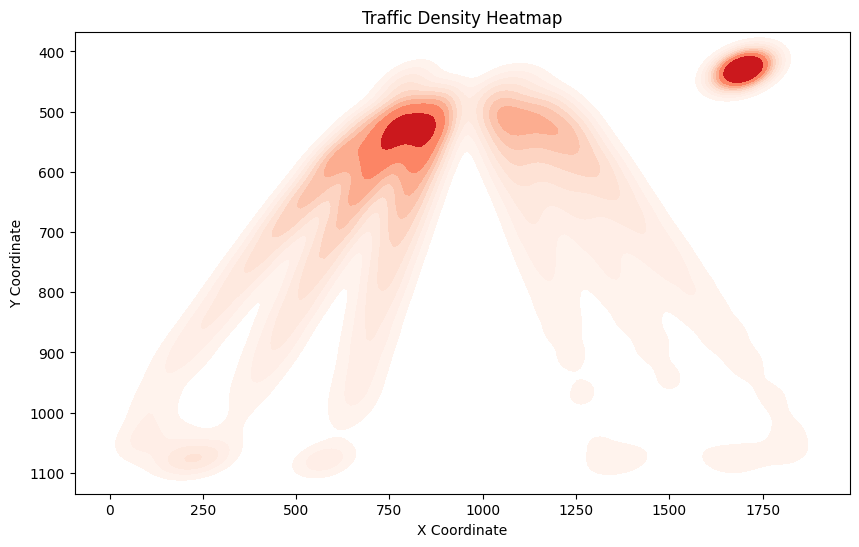

Average Reaction Time: nan
Reaction Time Distribution:
       Reaction Time (s)
count                  0
unique                 0
top                  NaN
freq                 NaN


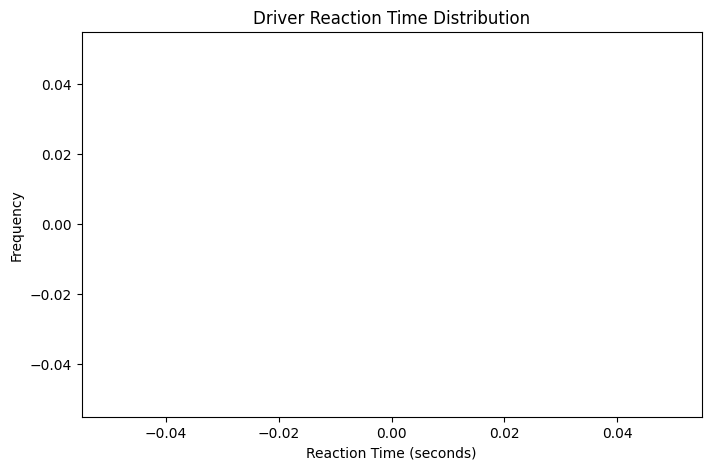

In [2]:
import cv2
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from ultralytics import YOLO
import supervision as sv
from collections import defaultdict, deque

# Load YOLO model
model = YOLO("yolov8n.pt")

# Define video source
video_path = "./asset/m6-motorway-trim.mp4"

# Define Stop Line Y-Coordinate
STOP_LINE_Y = 500  
WARNING_ZONE_Y = 300  

# Video Information
video_info = sv.VideoInfo.from_video_path(video_path)
video_info.fps = 25  

# ByteTrack Object Tracker
byte_track = sv.ByteTrack(frame_rate=video_info.fps, track_activation_threshold=0.3)

# Store vehicle movement data
vehicle_data = defaultdict(lambda: {"stopped": False, "stop_time": 0, "reaction_time": None})
reaction_times = []
heatmap_points = []

# Open Video Capture
cap = cv2.VideoCapture(video_path)
cap.set(cv2.CAP_PROP_BUFFERSIZE, 2)  # Reduce buffering for faster processing

frame_count = 0
FRAME_SKIP = 2  # Process every 2nd frame to improve speed

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break  # Stop if video ends

    frame_count += 1
    if frame_count % FRAME_SKIP != 0:
        continue  # Skip frames to improve speed

    # Run YOLOv8 Model
    results = model(frame)[0]
    detections = sv.Detections.from_ultralytics(results)
    detections = byte_track.update_with_detections(detections)

    # Analyze each detected vehicle
    for track_id, (x1, y1, x2, y2) in zip(detections.tracker_id, detections.xyxy):
        cx, cy = int((x1 + x2) / 2), int(y2)  # Bottom-center of vehicle
        
        # Save position for heatmap
        heatmap_points.append((cx, cy))

        # Detect stopping at STOP line
        if STOP_LINE_Y - 10 <= cy <= STOP_LINE_Y + 10:
            if not vehicle_data[track_id]["stopped"]:
                vehicle_data[track_id]["stopped"] = True
                vehicle_data[track_id]["stop_time"] = time.time()
        
        # Measure reaction time if moving after STOP
        if vehicle_data[track_id]["stopped"] and cy < WARNING_ZONE_Y:
            if vehicle_data[track_id]["reaction_time"] is None:
                vehicle_data[track_id]["reaction_time"] = time.time() - vehicle_data[track_id]["stop_time"]
                reaction_times.append(vehicle_data[track_id]["reaction_time"])

        # Draw box & tracking info
        cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
        cv2.putText(frame, f"ID {track_id}", (int(x1), int(y1)-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

    # Show video in real-time
    cv2.imshow("Road-User Behavior Analysis", frame)

    # Press 'q' to exit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

# Convert data for visualization
df_heatmap = pd.DataFrame(heatmap_points, columns=["x", "y"])
reaction_df = pd.DataFrame(reaction_times, columns=["Reaction Time (s)"])

# Generate heatmap
plt.figure(figsize=(10, 6))
sns.kdeplot(x=df_heatmap["x"], y=df_heatmap["y"], fill=True, bw_adjust=0.5, cmap="Reds")

plt.gca().invert_yaxis()  # Flip y-axis to match video coordinates
plt.title("Traffic Density Heatmap")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.show()

# Display reaction time statistics
print("Average Reaction Time:", reaction_df["Reaction Time (s)"].mean())
print("Reaction Time Distribution:")
print(reaction_df.describe())

# Plot reaction time distribution
plt.figure(figsize=(8, 5))
sns.histplot(reaction_df, bins=10, kde=True)
plt.title("Driver Reaction Time Distribution")
plt.xlabel("Reaction Time (seconds)")
plt.ylabel("Frequency")
plt.show()
